In [1]:
import torch
import pickle
import numpy as np
import time
from matplotlib import pyplot as plt
import matplotlib.patches as mpathes
import multiprocessing
import random
from common import find_grid_idx, extract_time_feat

In [2]:
folder = 'data/pkl/'
min_gps = np.array([104.042102,30.652828])
max_gps = np.array([104.129591,30.727818])

In [3]:
grid_data = pickle.load(open(folder + 'hex_grid.pkl', 'rb'))
'''
gx = np.array(grid_data['vertex'][:,:,0])
gy = np.array(grid_data['vertex'][:,:,1])

grid_data['vertex'][:,:,0] = gy
grid_data['vertex'][:,:,1] = gx

pickle.dump(grid_data, open(folder + 'hex_grid.pkl', 'wb'))
'''
'''
grid_mean = np.array(grid_data['vertex'])
grid_mean_x = grid_mean[:,:,0]
grid_mean_y = grid_mean[:,:,1]
grid_mean_x[grid_mean_x < min_gps[0]] = min_gps[0]
grid_mean_y[grid_mean_y < min_gps[1]] = min_gps[1]
grid_mean_x[grid_mean_x > max_gps[0]] = max_gps[0]
grid_mean_y[grid_mean_y > max_gps[1]] = max_gps[1]
print(grid_mean[:,:,0].min(),grid_mean[:,:,0].max())
print(grid_mean[:,:,1].min(),grid_mean[:,:,1].max())
grid_mean = grid_mean.mean(axis=1)
grid_data['mean'] = grid_mean
center = []
for i in grid_data['vertex']:
    center.append(i.mean(axis=0))
center = np.stack(center)
grid_data['center'] = center
'''
None

In [4]:
ride_req_data = pickle.load(open(folder + 'ride_req.pkl', 'rb'))

In [5]:
def isRayIntersectsSegment(poi,s_poi,e_poi): #[x,y] [lng,lat]
    #输入：判断点，边起点，边终点，都是[lng,lat]格式数组
    if s_poi[1]==e_poi[1]: #排除与射线平行、重合，线段首尾端点重合的情况
        return False
    if s_poi[1]>poi[1] and e_poi[1]>poi[1]: #线段在射线上边
        return False
    if s_poi[1]<poi[1] and e_poi[1]<poi[1]: #线段在射线下边
        return False
    if s_poi[1]==poi[1] and e_poi[1]>poi[1]: #交点为下端点，对应spoint
        return False
    if e_poi[1]==poi[1] and s_poi[1]>poi[1]: #交点为下端点，对应epoint
        return False
    if s_poi[0]<poi[0] and e_poi[0]<poi[0]: #线段在射线左边
        return False

    xseg=e_poi[0]-(e_poi[0]-s_poi[0])*(e_poi[1]-poi[1])/(e_poi[1]-s_poi[1]) #求交
    if xseg<poi[0]: #交点在射线起点的左侧
        return False
    return True  #排除上述情况之后

def isPoiWithinPoly(poi,poly):
    sinsc=0 #交点个数
    poly = [*poly, poly[0]]
    for s_poi, e_poi in zip(poly[:-1], poly[1:]): #[0,len-1]
        if isRayIntersectsSegment(poi,s_poi,e_poi):
            sinsc+=1 #有交点就加1

    return True if sinsc%2==1 else  False

def find_grid_idx(point, grid = grid_data):
    res = -1
    for i in range(len(grid['ID'])):
        if isPoiWithinPoly(point, grid['vertex'][i]):
            if res != -1:
                print(res, i, point)
            res = i
    return res

In [6]:
def extract_time_feat(ts):
    lt = time.localtime(ts)
    return lt.tm_mday, lt.tm_hour, lt.tm_wday, lt.tm_wday >= 5

查看数据分布。存在脏数据，碰到要忽略

In [7]:
ride_req_data['pos'].min(),ride_req_data['pos'].max()
r = ride_req_data['pos']
print(r.shape)
print(np.histogram(r[:,:,0].reshape(-1)))
print(np.histogram(r[:,:,1].reshape(-1)))
print(grid_data['vertex'].min())
print(grid_data['vertex'].max())
v = grid_data['vertex']
print(v.shape)
print(np.histogram(v[:,:,0].reshape(-1)))
print(np.histogram(v[:,:,1].reshape(-1)))

(7065937, 2, 2)
(array([     163,        0,        0,        0,        0,        0,
              0,        0, 14131702,        9]), array([  0.      ,  12.036152,  24.072304,  36.108456,  48.144608,
        60.18076 ,  72.216912,  84.253064,  96.289216, 108.325368,
       120.36152 ]))
(array([     163,        0,        0,        0,        0,        3,
              3, 14131701,        2,        2]), array([ 0.      ,  4.014547,  8.029094, 12.043641, 16.058188, 20.072735,
       24.087282, 28.101829, 32.116376, 36.130923, 40.14547 ]))
22.85281
120.36612
(8518, 6, 2)
(array([50062,   940,    58,     0,     0,    12,     6,     6,    18,
           6]), array([102.99358 , 104.730834, 106.468088, 108.205342, 109.942596,
       111.67985 , 113.417104, 115.154358, 116.891612, 118.628866,
       120.36612 ]))
(array([   18,     6,     6,   131, 50881,    48,     6,     0,     0,
          12]), array([22.85281 , 24.582904, 26.312998, 28.043092, 29.773186, 31.50328 ,
       33.233374, 34.963

多线程查找每个轨迹起点所在区域

In [11]:
threadnum = 29

select_length = len(ride_req_data['ID'])

class req_calc_thread(multiprocessing.Process):
    def __init__ (self, threadID, start, inputdata, sharelist):
        multiprocessing.Process.__init__(self)
        self.ID = threadID
        self.start_pos = start
        self.inputdata = inputdata
        self.sharelist = sharelist
        print('thread %d: item length = %d' % (threadID, len(self.inputdata)))
    
    def run(self):
        start_time = time.time()
        count = 0
        for pos in self.inputdata:
            #t = extract_time_feat(t[0])
            s_pos = find_grid_idx(pos)
            self.sharelist[self.start_pos + count] = s_pos
            if s_pos == -1: print(pos)
            count += 1
            if self.ID == threadnum - 1 and count % 1000 == 0:
                print(self.ID, count, time.time() - start_time)

count = 0
m = {}
req_zipped = []
for i in list(zip(ride_req_data['ID'], ride_req_data['time'], ride_req_data['pos'], ride_req_data['reward'])):
    if i[0] not in m:
        req_zipped.append(i)
        m[i[0]] = 1
        
print(len(req_zipped))

req_zipped = list(zip(ride_req_data['ID'], ride_req_data['time'], ride_req_data['pos'], ride_req_data['reward']))[:select_length]

manager = multiprocessing.Manager()
sharelist = manager.list()
for i in range(len(req_zipped)):
    sharelist.append(0)
    if i % 10000 == 0:
        print('sharelist append %d' % i)

threads = []
pos = ride_req_data['pos'][:select_length,1]
print(pos.shape)
for i in range(threadnum):
    delta = len(pos) // threadnum
    start = delta * i
    end = start + delta
    if i + 1 == threadnum:
        end = len(pos)
    #print(i, start, end)
    threads.append(req_calc_thread(i, start, pos[start:end], sharelist))
    threads[i].start()
for t in threads:
    t.join()
print('end over')
end_grid = list(sharelist)

threads = []
pos = ride_req_data['pos'][:select_length,0]
print(pos.shape)
for i in range(threadnum):
    delta = len(pos) // threadnum
    start = delta * i
    end = start + delta
    if i + 1 == threadnum:
        end = len(pos)
    #print(i, start, end)
    threads.append(req_calc_thread(i, start, pos[start:end], sharelist))
    threads[i].start()
for t in threads:
    t.join()
print('start over')
start_grid = list(sharelist)

ride_req_data['start_grid'] = start_grid
ride_req_data['end_grid'] = end_grid
pickle.dump(ride_req_data, open(folder + 'ride_req.pkl', 'wb'))

6105003
sharelist append 0
(3210, 2)
thread 0: item length = 110
thread 1: item length = 110
thread 2: item length = 110
thread 3: item length = 110
thread 4: item length = 110
thread 5: item length = 110
thread 6: item length = 110
thread 7: item length = 110
thread 8: item length = 110
thread 9: item length = 110
thread 10: item length = 110
thread 11: item length = 110
thread 12: item length = 110
thread 13: item length = 110
thread 14: item length = 110
thread 15: item length = 110
thread 16: item length = 110
thread 17: item length = 110
thread 18: item length = 110
thread 19: item length = 110
thread 20: item length = 110
thread 21: item length = 110
thread 22: item length = 110
thread 23: item length = 110
thread 24: item length = 110
thread 25: item length = 110
thread 26: item length = 110
thread 27: item length = 110
thread 28: item length = 130
end over
(3210, 2)
thread 0: item length = 110
thread 1: item length = 110
thread 2: item length = 110
thread 3: item length = 110
t

In [7]:
ride_req_data.keys()

dict_keys(['pos', 'ID', 'grid', 'time', 'reward', 'end_grid', 'start_grid'])

In [85]:
grid_order_count = np.zeros((len(grid_data['ID']) + 1, 31, 24, 7), dtype='int')
grid_reward_count = np.zeros((len(grid_data['ID']) + 1, 31, 24, 7), dtype='float')

req_zipped = list(zip(ride_req_data['ID'], ride_req_data['start_grid'], ride_req_data['time'], ride_req_data['pos'], ride_req_data['reward']))

m = set()

for num, [i, s_pos, t, pos, re] in enumerate(req_zipped):
    if i in m:
        continue
    m.add(i)
    t = extract_time_feat(t[0])
    grid_order_count[s_pos, t[0], t[1], t[2]] += 1
    grid_reward_count[s_pos, t[0], t[1], t[2]] += re
grid_order_count = grid_order_count[:-1,1:]
grid_reward_count = grid_reward_count[:-1,1:]

In [86]:
print(grid_order_count.shape, grid_reward_count.shape)

(8518, 30, 24, 7) (8518, 30, 24, 7)


In [155]:
grid_order = np.array(grid_order_count).sum(axis=1)
grid_reward = np.array(grid_reward_count).sum(axis=1)
grid_order[grid_order == 0] = 1
grid_reward /= grid_order
grid_order = np.array(grid_order_count).sum(axis=1)
pickle.dump({'order': grid_order, 'reward': grid_reward}, open(folder + 'grid_order_reward.pkl', 'wb'))

In [102]:
print(grid_order.max(), grid_reward.max())
print(grid_order.shape, grid_reward.shape)

3604 93.05
(8518, 24, 7) (8518, 24, 7)


处理取消概率数据

In [8]:
cancel_data = pickle.load(open(folder + 'cancel_prob.pkl', 'rb'))

In [114]:
m = {}
for i, p in zip(cancel_data['ID'], cancel_data['prob']):
    if i in m.keys():
        if (p != m[i]).any():
            print(i, p, m[i])
            break
        continue
    m[i] = p

In [115]:
m = {}
for i, t, pos, re in zip(ride_req_data['ID'], ride_req_data['time'], ride_req_data['pos'], ride_req_data['reward']):
    if i in m.keys():
        if (t != m[i][0]).any() or (pos != m[i][1]).any() or (re != m[i][2]).any():
            print(i, t, pos, re, m[i])
            break
        continue
    m[i] = [t,pos,re]

In [118]:
print(cancel_data['prob'].shape, len(m))

(7065937, 10) 6105003


In [127]:
m = set()
# startG, endG, hour, weekday, isweekend, reward, order ETA
cancel_train = []
L = len(cancel_data['ID'])
for i in range(L):
    ID = cancel_data['ID'][i]
    if ID in m:
        continue
    m.add(ID)
    startG = ride_req_data['start_grid'][i]
    endG = ride_req_data['end_grid'][i]
    t = ride_req_data['time'][i]
    st = extract_time_feat(t[0])
    hour = st[1]
    weekday = st[2]
    isweekend = st[3]
    reward = ride_req_data['reward'][i]
    ETA = t[1] - t[0]
    prob = cancel_data['prob'][i]
    if startG == -1 or endG == -1:
        #print([ride_req_data['pos'][i], endG, hour, weekday, isweekend, reward, ETA, prob])
        continue
    cancel_train.append([startG, endG, hour, weekday, isweekend, reward, ETA, prob])

In [128]:
print(len(cancel_train))
startG, endG, hour, weekday, isweekend, reward, ETA, prob = list(zip(*cancel_train))
GID = np.array(list(zip(startG, endG)))
splittime = np.array(list(zip(hour, weekday, isweekend)))
reward = np.array(reward)
ETA = np.array(ETA)
prob = np.array(prob)

cancel_train = {
    'GID': GID,
    'time': splittime,
    'reward': reward,
    'ETA': ETA,
    'prob': prob
}
pickle.dump(cancel_train, open(folder + 'cancel_prob_train.pkl', 'wb'))

6104887


In [124]:
cancel_train

{'ETA': array([1710, 2090, 1265, ..., 2145, 1545, 1031]),
 'GID': array([[3046, 3944],
        [6400, 5081],
        [6912, 1720],
        ...,
        [5422, 6971],
        [7839,   60],
        [3735, 4176]]),
 'prob': array([[0.008606, 0.008098, 0.008355, ..., 0.042079, 0.043802, 0.046584],
        [0.117864, 0.126627, 0.134129, ..., 0.210413, 0.227839, 0.237643],
        [0.011333, 0.010759, 0.011035, ..., 0.041103, 0.044903, 0.050505],
        ...,
        [0.008664, 0.009315, 0.009673, ..., 0.046172, 0.050188, 0.056687],
        [0.013174, 0.014159, 0.014555, ..., 0.05161 , 0.056076, 0.063198],
        [0.012617, 0.010593, 0.010353, ..., 0.058398, 0.070243, 0.084266]]),
 'reward': array([ 3.54, 11.7 ,  5.01, ...,  5.27,  5.72,  2.38]),
 'time': array([[ 9,  1,  0],
        [15,  1,  0],
        [20,  1,  0],
        ...,
        [20,  2,  0],
        [18,  2,  0],
        [19,  2,  0]])}

CarEnv所需的actions数据格式

In [161]:
action_data_raw = pickle.load(open(folder + 'cancel_prob_train.pkl', 'rb'))

In [162]:
action_data = [[[[[] for zz in range(4)] for z in range(7)] for y in range(24)] for x in range(len(grid_data['ID']))]

In [163]:
for gid, reward, t, prob, eta in zip(*[action_data_raw[x] for x in ['GID', 'reward', 'time', 'prob', 'ETA']]):
    #print(gid, time)
    select = action_data[gid[0]][t[0]][t[1]]
    select[0].append(gid[1])
    select[1].append(eta)
    select[2].append(reward)
    select[3].append(prob)

In [164]:
for i in range(len(grid_data['ID'])):
    for j in range(24):
        for k in range(7):
            action_data[i][j][k] = [np.array(x) for x in action_data[i][j][k]]

In [166]:
pickle.dump(action_data, open(folder + 'carenv_actions.pkl', 'wb'))

## 按照矩形切

In [9]:
min_gps = np.array([103.8,30.45])
max_gps = np.array([104.3,30.9])
delta_gps = max_gps - min_gps
real_distance = np.array([47720.28483581, 50106.68089079])
block_number = np.array([50, 50])

In [10]:
blocks = block_number[0] * block_number[1]

In [334]:
grid_order_count = np.zeros((blocks, 24), dtype='int')
grid_reward_count = np.zeros((blocks, 24), dtype='float')

req_zipped = list(zip(ride_req_data['ID'], ride_req_data['time'], ride_req_data['pos'], ride_req_data['reward']))

m = set()

for num, [i, t, pos, re] in enumerate(req_zipped):
    if num % 100000 == 0:
        print(num, '/', len(req_zipped))
    if i in m:
        continue
    m.add(i)
    t = time.localtime(t[0]).tm_hour
    if (pos[0] < min_gps).any() or (pos[0] > max_gps).any():
        #print(pos[0])
        continue
    s_pos = (((pos[0] - min_gps) / (max_gps - min_gps) * block_number).astype(int) * [block_number[1], 1]).sum()
    #print(pos[0] - min_gps,(pos[0] - min_gps) / (max_gps - min_gps),(pos[0] - min_gps) / (max_gps - min_gps) * block_number,pos, s_pos)
    grid_order_count[s_pos, t] += 1
    grid_reward_count[s_pos, t] += re

0 / 7065937
100000 / 7065937
200000 / 7065937
300000 / 7065937
400000 / 7065937
500000 / 7065937
600000 / 7065937
700000 / 7065937
800000 / 7065937
900000 / 7065937
1000000 / 7065937
1100000 / 7065937
1200000 / 7065937
1300000 / 7065937
1400000 / 7065937
1500000 / 7065937
1600000 / 7065937
1700000 / 7065937
1800000 / 7065937
1900000 / 7065937
2000000 / 7065937
2100000 / 7065937
2200000 / 7065937
2300000 / 7065937
2400000 / 7065937
2500000 / 7065937
2600000 / 7065937
2700000 / 7065937
2800000 / 7065937
2900000 / 7065937
3000000 / 7065937
3100000 / 7065937
3200000 / 7065937
3300000 / 7065937
3400000 / 7065937
3500000 / 7065937
3600000 / 7065937
3700000 / 7065937
3800000 / 7065937
3900000 / 7065937
4000000 / 7065937
4100000 / 7065937
4200000 / 7065937
4300000 / 7065937
4400000 / 7065937
4500000 / 7065937
4600000 / 7065937
4700000 / 7065937
4800000 / 7065937
4900000 / 7065937
5000000 / 7065937
5100000 / 7065937
5200000 / 7065937
5300000 / 7065937
5400000 / 7065937
5500000 / 7065937
5600000

In [11]:
print(grid_order_count.shape, grid_reward_count.shape)

NameError: name 'grid_order_count' is not defined

In [336]:
grid_order = np.array(grid_order_count)
grid_reward = np.array(grid_reward_count)
grid_order[grid_order == 0] = 1
grid_reward /= grid_order
grid_order = np.array(grid_order_count)
pickle.dump({'order': grid_order, 'reward': grid_reward}, open(folder + 'grid_order_reward.pkl', 'wb'))

In [337]:
print(grid_order.max(), grid_reward.max())
print(grid_order.shape, grid_reward.shape)

15761 93.05
(2500, 24) (2500, 24)


处理取消概率数据

In [17]:
cancel_data = pickle.load(open(folder + 'cancel_prob.pkl', 'rb'))

In [18]:
m = {}
for i, p in zip(cancel_data['ID'], cancel_data['prob']):
    if i in m.keys():
        if (p != m[i]).any():
            print(i, p, m[i])
            break
        continue
    m[i] = p

In [19]:
m = {}
for i, t, pos, re in zip(ride_req_data['ID'], ride_req_data['time'], ride_req_data['pos'], ride_req_data['reward']):
    if i in m.keys():
        if (t != m[i][0]).any() or (pos != m[i][1]).any() or (re != m[i][2]).any():
            print(i, t, pos, re, m[i])
            break
        continue
    m[i] = [t,pos,re]

KeyboardInterrupt: 

In [ ]:
print(cancel_data['prob'].shape, len(m))

In [ ]:
m = set()
# startG, endG, hour, weekday, isweekend, reward, order ETA
cancel_train = []
L = len(cancel_data['ID'])
for i in range(L):
    ID = cancel_data['ID'][i]
    if ID in m:
        continue
    m.add(ID)
    startG = ride_req_data['start_grid'][i]
    endG = ride_req_data['end_grid'][i]
    startPos = ride_req_data['pos'][i][0]
    endPos = ride_req_data['pos'][i][1]
    if (startPos < min_gps - delta_gps).any() or (startPos > max_gps + delta_gps).any():
        continue
    if (endPos < min_gps - delta_gps).any() or (endPos > max_gps + delta_gps).any():
        continue
    t = ride_req_data['time'][i]
    hour = time.localtime(t[0]).tm_hour
    reward = ride_req_data['reward'][i]
    ETA = t[1] - t[0]
    prob = cancel_data['prob'][i]
    #if startG == -1 or endG == -1:
        #print([ride_req_data['pos'][i], endG, hour, weekday, isweekend, reward, ETA, prob])
    #    continue
    cancel_train.append([[startPos, endPos], hour, reward, ETA, prob])

In [ ]:
print(len(cancel_train))
pos, hour, reward, ETA, prob = list(zip(*cancel_train))
pos = np.array(pos)
hour = np.array(hour)
reward = np.array(reward)
ETA = np.array(ETA)
prob = np.array(prob)

cancel_train = {
    'pos': pos,
    'hour': hour,
    'reward': reward,
    'ETA': ETA,
    'prob': prob
}
pickle.dump(cancel_train, open(folder + 'cancel_prob_train.pkl', 'wb'))

In [21]:
cancel_train = pickle.load(open(folder + 'cancel_prob_train.pkl', 'rb'))

In [22]:
cancel_train['pos']

array([[[104.09464 ,  30.703971],
        [104.08927 ,  30.65085 ]],

       [[104.076509,  30.76743 ],
        [104.0637  ,  30.58951 ]],

       [[104.019699,  30.689007],
        [104.105324,  30.66395 ]],

       ...,

       [[104.10051 ,  30.6992  ],
        [104.05618 ,  30.63636 ]],

       [[104.1601  ,  30.62708 ],
        [104.08077 ,  30.69049 ]],

       [[104.080394,  30.683514],
        [104.11684 ,  30.67172 ]]])

In [23]:
ride_req_data['pos'].min()

0.0

In [24]:
for key in cancel_train:
    print(cancel_train[key].shape)

(6104884, 2, 2)
(6104884, 10)
(6104884,)
(6104884,)
(6104884,)


根据现有数据计算转移矩阵

CarEnv所需的actions数据格式

In [61]:
action_data_raw = pickle.load(open(folder + 'cancel_prob_train.pkl', 'rb'))

In [62]:
action_data = [[[[] for z in range(7)] for y in range(24)] for x in range(blocks)]

In [63]:
action_data_raw['hour']

array([ 9, 15, 20, ..., 20, 18, 19])

In [64]:
for pos, reward, hour, prob, eta in zip(*[action_data_raw[x] for x in ['pos', 'reward', 'hour', 'prob', 'ETA']]):
    #print(gid, time)
    #print(pos)
    if (pos[0] < min_gps).any() or (pos[0] > max_gps).any():
        continue
    pos = (pos - min_gps) / delta_gps
    block_idx = ((pos[0] * block_number).astype(int) * [block_number[1], 1]).sum()
    #print(pos, block_idx)
    #if np.random.random() < 0.01: break
    select = action_data[block_idx][hour]
    select[0].append(pos[0][0])
    select[1].append(pos[0][1])
    select[2].append(pos[1][0])
    select[3].append(pos[1][1])
    select[4].append(eta)
    select[5].append(reward)
    select[6].append(prob)

In [65]:
for i in range(blocks):
    for j in range(24):
        action_data[i][j] = [np.array(x) for x in action_data[i][j]]

In [70]:
pickle.dump(action_data, open(folder + 'carenv_actions.pkl', 'wb'))

In [54]:
action_data = pickle.load(open(folder + 'carenv_actions.pkl', 'rb'))

In [66]:
len(action_data)

2500

In [67]:
len(action_data[0])

24

In [69]:
action_data[1441][21]

[array([0.5738  , 0.5738  , 0.560598, 0.575324, 0.56836 , 0.5642  ,
        0.5738  , 0.5738  , 0.579718, 0.5738  , 0.5738  ]),
 array([0.83273333, 0.83273333, 0.82168222, 0.83899778, 0.82322222,
        0.82071333, 0.83273333, 0.83273333, 0.82726222, 0.83273333,
        0.83273333]),
 array([0.52632 , 0.52024 , 0.566568, 0.58906 , 0.54648 , 0.3933  ,
        0.52632 , 0.54806 , 0.58318 , 0.54806 , 0.42086 ]),
 array([0.56731111, 0.60502222, 0.56670889, 0.47208889, 0.57448889,
        0.34882222, 0.56731111, 0.52511111, 0.5452    , 0.52511111,
        0.57      ]),
 array([2279, 3729, 1484, 2002, 1358, 3118, 1767, 3456, 2332, 2513, 2909]),
 array([ 7.36,  8.53,  5.97,  9.5 ,  6.01, 16.26,  6.28,  9.12,  7.63,
         8.8 ,  9.72]),
 array([[0.022142, 0.023704, 0.024602, 0.027309, 0.035534, 0.049117,
         0.056902, 0.060278, 0.066741, 0.072941],
        [0.029049, 0.031084, 0.032253, 0.036037, 0.03927 , 0.049629,
         0.057489, 0.060899, 0.067423, 0.072075],
        [0.022054, 

Tests

In [180]:
ra,rb,rc = np.random.randint(len(grid_data['ID'])),np.random.randint(24),np.random.randint(7)
print(ra,rb,rc)
action_data[ra][rb][rc]

5825 23 6


[array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64)]

In [ ]:
plt.figure(figsize=(17,17))


(103.19194719818681, 104.65707480181321) (30.129023339198373, 31.13806666080163)


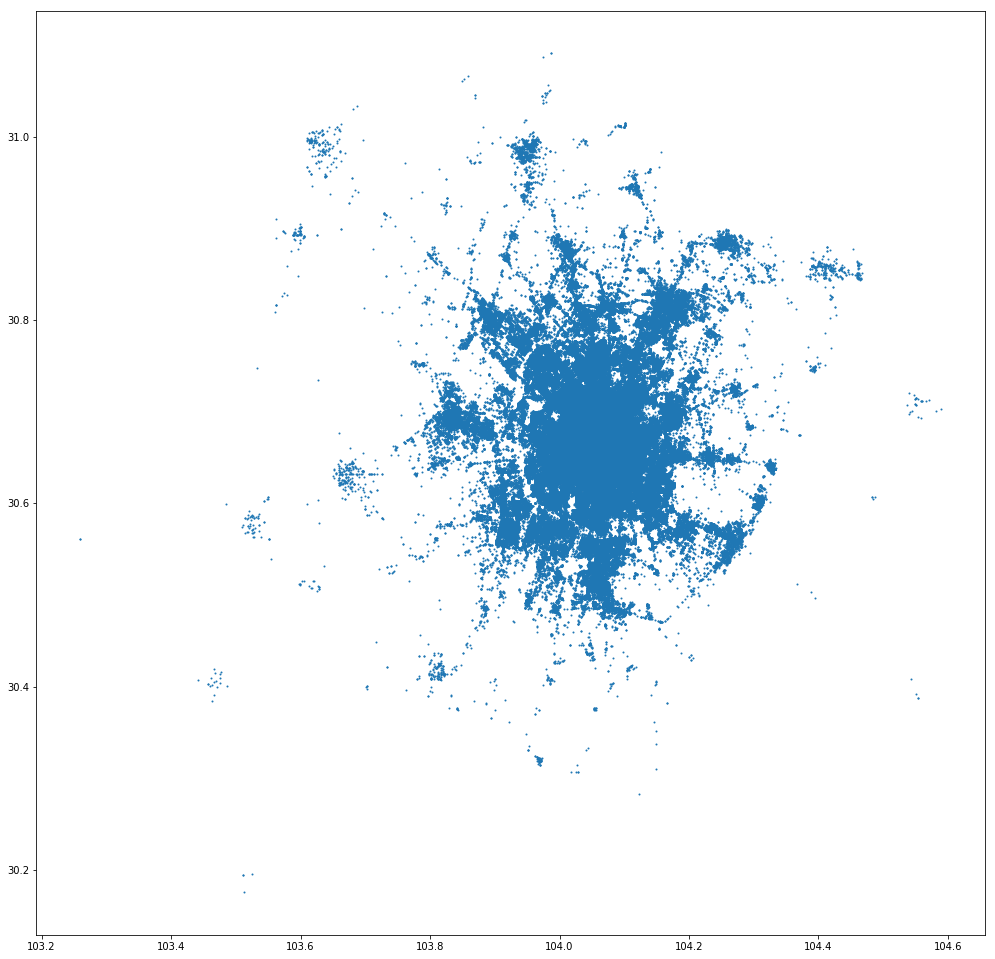

In [206]:
posd = ride_req_data['pos'][:,0,:]
plt.figure(figsize=(17,17))
plt.scatter(posd[:,0], posd[:,1], s = 1)
print(plt.xlim(), plt.ylim())
plt.show()

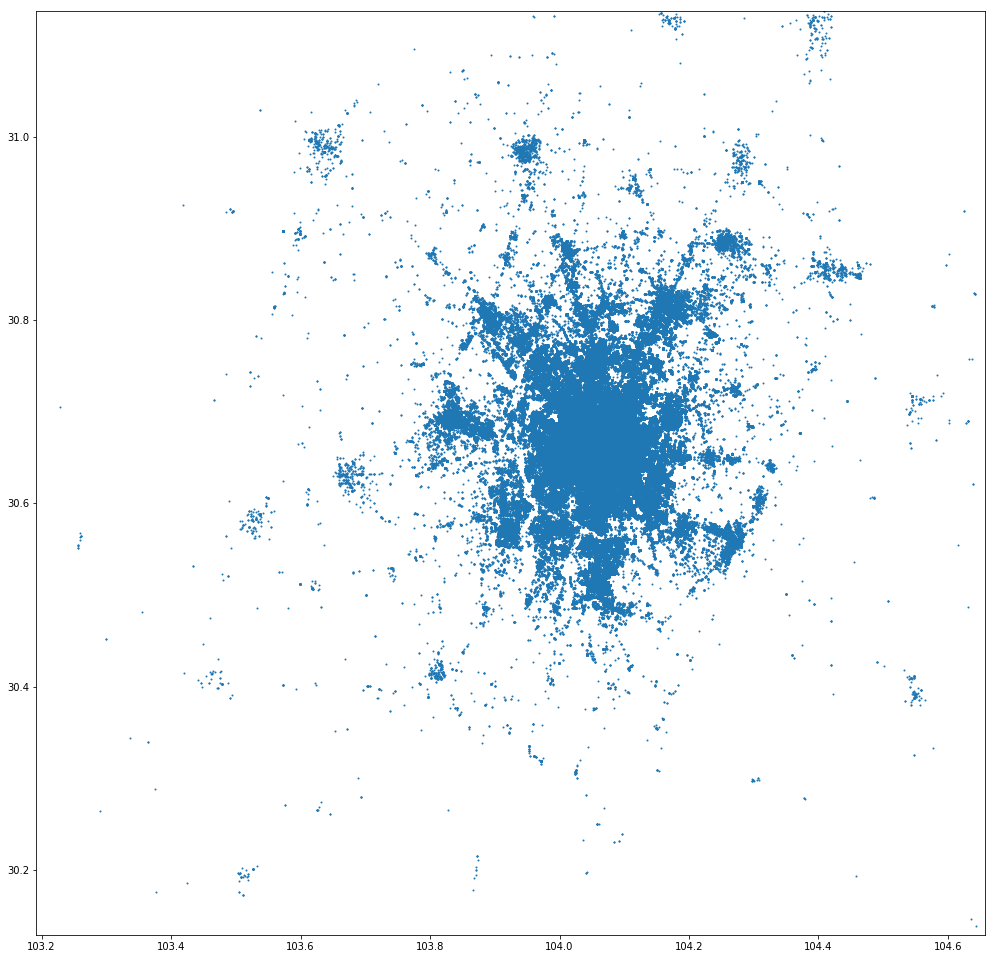

In [211]:
posd = ride_req_data['pos'][:,1,:]
plt.figure(figsize=(17,17))
plt.scatter(posd[:,0], posd[:,1], s = 1)
plt.xlim(103.19194719818681, 104.65707480181321)
plt.ylim(30.129023339198373, 31.13806666080163)
plt.show()

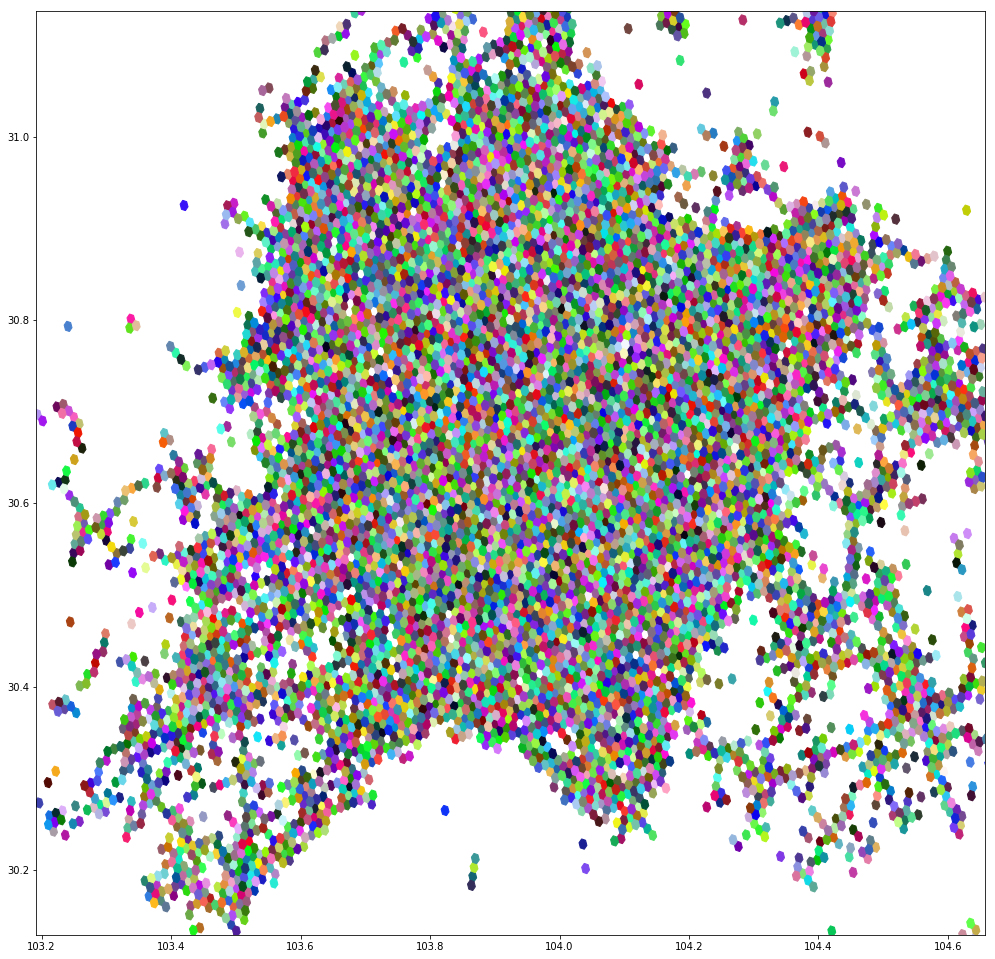

In [231]:
select = np.array([False] * len(vx))
for i in ride_req_data['start_grid']:
    if i != -1:
        select[i] = True
vx = grid_data['vertex']
plt.figure(figsize=(17,17))
for num, i in enumerate(vx):
    plt.fill(i[:,0], i[:,1], color=[random.random(),random.random(),random.random(),1.0])
plt.xlim(103.19194719818681, 104.65707480181321)
plt.ylim(30.129023339198373, 31.13806666080163)
plt.show()

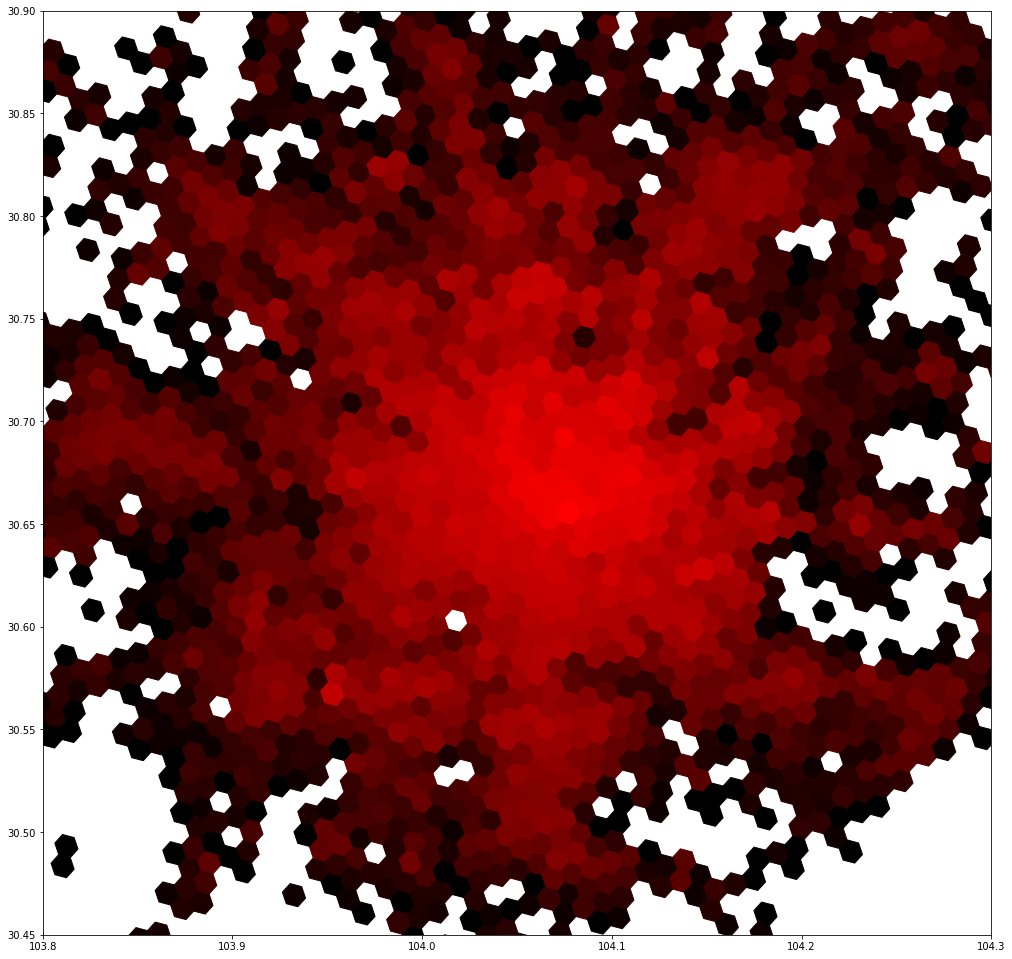

In [313]:
select = np.array([0.] * len(vx))
for i in ride_req_data['start_grid']:
    if i != -1:
        select[i] += 1
select_ori = select.copy()
select[select == 0] = 1e-100
select = np.log(select)
select /= select.max()
vx = grid_data['vertex']
plt.figure(figsize=(17,17))
for num, i in enumerate(vx):
    if select[num] < 0:
        continue
    plt.fill(i[:,0], i[:,1], color=[select[num],0,0,1.0])
plt.xlim(103.8, 104.3)
plt.ylim(30.45, 30.9)
#plt.xlim(103.19194719818681, 104.65707480181321)
#plt.ylim(30.129023339198373, 31.13806666080163)
plt.show()

In [308]:
count = 0
'''
for num, [i, gid] in enumerate(zip(ride_req_data['pos'], ride_req_data['start_grid'])):
    if True or select[gid] < 0:
        i = i[0]
        minxy = [103.5, 30.4]
        maxxy = [104.5, 31]
        if (i < minxy).any() or (i > maxxy).any():
            count += 1
'''
for num, i in enumerate(vx):
    i = i.mean(axis=0)
    minxy = [103.8, 30.45]
    maxxy = [104.3, 30.9]
    if (i < minxy).any() or (i > maxxy).any():
        count += select_ori[num]
print(count, select_ori.sum())

4676.0 7065937.0


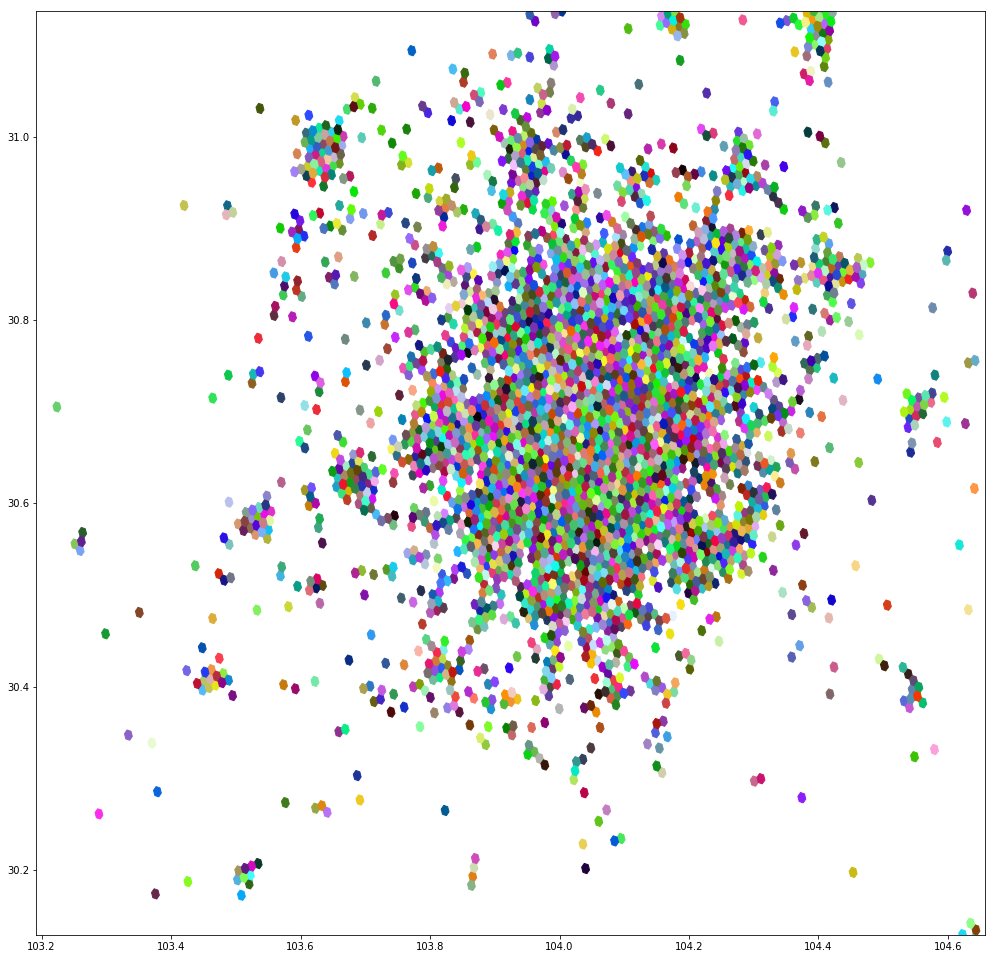

In [232]:
select = np.array([False] * len(vx))
for i in ride_req_data['end_grid']:
    if i != -1:
        select[i] = True
vx = grid_data['vertex']
plt.figure(figsize=(17,17))
for num, i in enumerate(vx):
    if not select[num]:
        continue
    plt.fill(i[:,0], i[:,1], color=[random.random(),random.random(),random.random(),1.0])
plt.xlim(103.19194719818681, 104.65707480181321)
plt.ylim(30.129023339198373, 31.13806666080163)
plt.show()

In [260]:
min_gps = np.array([104.042102,30.652828])
max_gps = np.array([104.129591,30.727818])
one_meter = (max_gps - min_gps) / 8350

In [262]:
[-(103.19194719818681- 104.65707480181321),
-(30.129023339198373- 31.13806666080163)] / one_meter

array([139832.6131317 , 112355.13715678])

In [310]:
[0.5,0.45]/one_meter

array([47720.28483581, 50106.68089079])

In [259]:
grid_order.sum(axis=0)

array([[15033, 18332, 18385, 14972, 15138, 21053, 19826],
       [ 9536, 11944, 11659,  9666, 10117, 14469, 13627],
       [ 6004,  7963,  7758,  6381,  6991,  9682,  9108],
       [ 3961,  5005,  4996,  4172,  4226,  6150,  5738],
       [ 3925,  5003,  4890,  3979,  4059,  5241,  5011],
       [ 3946,  4929,  4350,  3560,  3732,  4923,  4075],
       [ 7393,  8966,  8881,  7160,  7507,  7855,  6264],
       [31805, 38294, 38342, 32092, 33003, 24515, 19012],
       [42668, 54521, 54397, 44911, 46204, 39633, 34240],
       [51871, 65219, 66842, 51307, 52693, 44535, 39540],
       [47489, 59012, 60159, 45884, 47812, 45126, 41642],
       [44709, 55636, 56630, 43761, 45752, 48180, 45599],
       [43572, 55209, 55549, 43847, 47233, 49624, 47485],
       [54093, 66913, 68256, 53439, 55845, 56492, 54999],
       [54305, 66524, 67912, 51838, 56563, 56719, 55639],
       [50660, 60705, 61807, 48028, 53414, 51579, 51060],
       [48165, 59356, 59915, 47288, 52327, 51057, 50021],
       [49145,

In [242]:
tp = pickle.load(open(folder + 'trans_prob.pkl', 'rb'))
tp.keys()

dict_keys(['prob', 'ID', 'time'])

In [250]:
for prob, id, t in zip(tp['prob'], tp['ID'], tp['time']):
    if prob == 1 and id[0] != id[1]:
        print(id, t)

[ 8136580836003271138 12523392035948386814] 5
[ 5013741680200143006 13841317068870942741] 12
